### Hierarchical Clustering
This method is a cluster algorithm, containing top-down and bottom-up method.    
We will try to seperate pixels into different clusters, corresponding to different FC preference.

Steps are as follows:
1. Standarize and calculate distance matrix.
2. Calculate dentrogram
3. Select clust num or cutoff level and visualize clust results

You can also try this method to clust time series, indicating different state of brain activation.

In [1]:
#%% import 
import Common_Functions as cf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
from tqdm import tqdm
import pandas as pd
from Brain_Atlas.Atlas_Mask import Mask_Generator
from Atlas_Corr_Tools import *
from scipy.stats import pearsonr
from Signal_Functions.Pattern_Tools import Do_PCA
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
import time

wp = r'D:\_DataTemp\OIS\Wild_Type\Preprocessed'
MG = Mask_Generator(bin=4)

# on_response is 1D vectorized pixel response, on_mask is location of each vector.
on_response,on_mask = cf.Load_Variable(wp,'Response_1d.pkl')
print(on_response.shape)

(1574, 18025)


___
#### Step1, standarize and calculate distance matrix.    
I already clipped response to -3~3. You might need to clip data that before standarization.

In [13]:
# standarize time series.
normalized_ts = (on_response - on_response.mean(1,keepdims=True))/on_response.std(1,keepdims=True) # keepdims will not perform sqeeze, otherwise this cannot sub&divide directly.

normalized_ts.shape

(1574, 18025)

- After standarization, getting distance matrix.    

scipy provide a direct method for distance calculation. Multiple method included.    
You can check https://docs.scipy.org/doc/scipy/reference/generated/scipy.spatial.distance.pdist.html for detail.    


In [14]:
from scipy.spatial.distance import pdist,squareform

distance_metric = 'cityblock'
# cityblock return L1 norm of data. Different matrix return some different results.
# Multiple options: 'euclidean', 'correlation', 'cityblock','chebyshev',.....

distance_matrix = pdist(normalized_ts , metric=distance_metric)
distance_matrix.shape

(1237951,)

len(distance_matrix) = N*(N-1)/2
- This method will give you dense distance matrix, but you can return it back to corr matrix easily.    


True


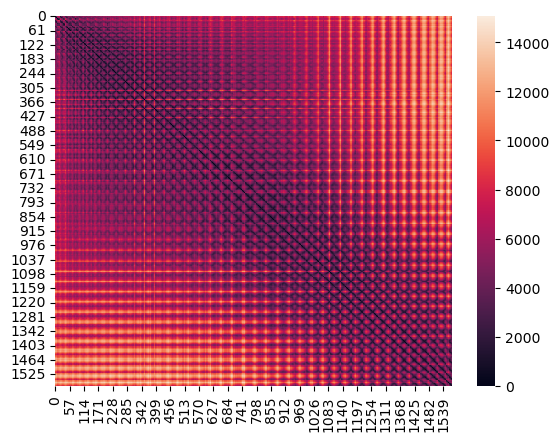

In [ ]:
square_matrix = squareform(distance_matrix) 
sns.heatmap(square_matrix)

# you can also use this function to transform distance matrix into dense 1D corr info.
recovered_matrix = squareform(square_matrix)

# test whether recovered matrix is the same as original
print((recovered_matrix == distance_matrix).min())

___
#### Step2, build Hierarchical Dendrogram Linkage
Use scipy pkg, this work is very easy.

In [19]:
Z = linkage(distance_matrix, method='ward',metric=distance_metric )

print(Z.shape)
print(Z[0])

(1573, 4)
[1387.         1427.          406.60410488    2.        ]


##### ↑ What's this mean?
Z recorded every step of combination. As we have 1574 pix, there will be 1573 steps of calculation.    

Each step combine nearest 2 element, in shape:    
[elementA,elementB,distance,element num in cluster]    

If combine generate a new cluster, the cluster will have a new id.


- After that, we can plot dendrogram.

[]

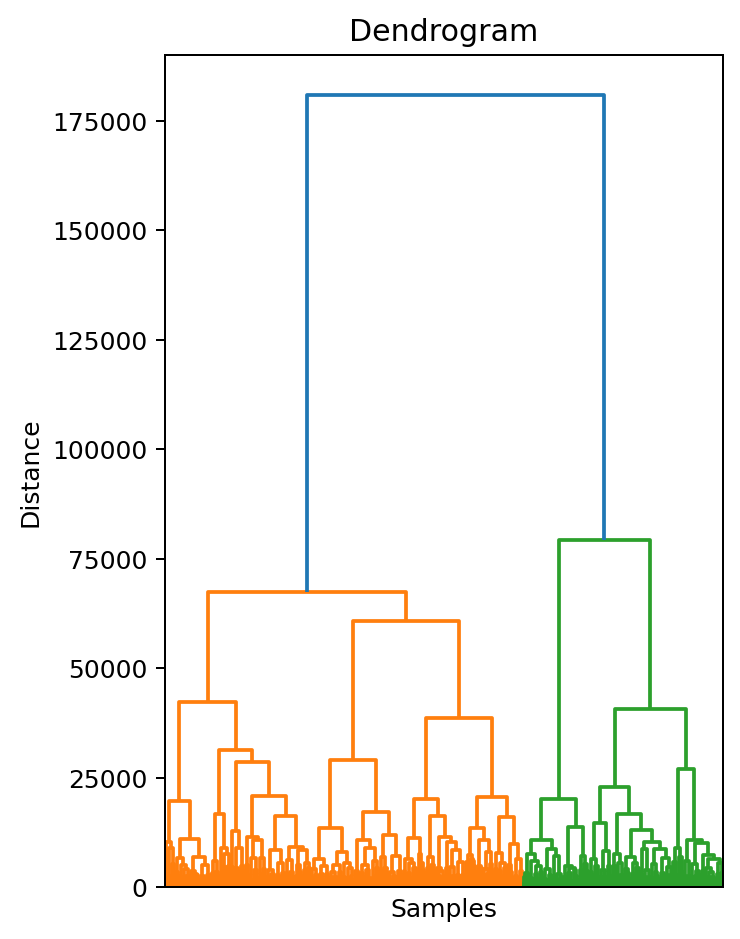

In [ ]:
fig,ax = plt.subplots(ncols=1,nrows=1,figsize = (4,6),dpi = 180)
a = dendrogram(
    Z,
    truncate_mode='lastp',  # Show only the last p merged clusters
    p=25000,                   #Steps of cluster to show. set very big will show whole dentrogram.
    show_leaf_counts=True,
    leaf_rotation=90, # rotation angle of leaf 
    leaf_font_size=6, # fontsize of leaf
    ax = ax,
    orientation= 'top' # Orientation of cluster going on. top as default.
)
ax.set_title('Dendrogram')
ax.set_xlabel('Samples')
ax.set_ylabel('Distance')
ax.set_xticks([]) # Mute x label if you want full graph.

___ 
#### Step 3, recover cluster map.
First select cut-off level or cluster number.     
Then you can visualize cluster to raw map.

**Compare cluster will help you recognize pathological state.**

[2 2 2 ... 8 8 8]


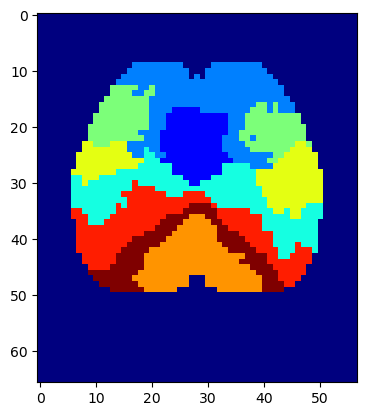

In [44]:
# method 1, show cluster by selecting cluster num directly.
n_clusters = 8
clusters = fcluster(Z, t=n_clusters, criterion='maxclust')
print(clusters) # cluster is a list of id, indicating the cluster of each pix.

# then visualize.
recover = copy.deepcopy(on_mask).astype('i4')
recover[recover==True] = clusters
plt.imshow(recover,cmap='jet')

Level 40000 have 7 Clusters


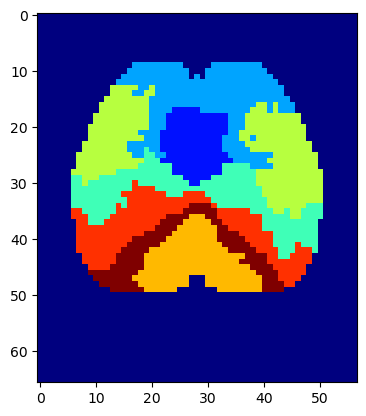

In [47]:
# method 2, show cluster by selecting cut-off distance.
cutoff_distance =40000 
clusters = fcluster(Z, t=cutoff_distance, criterion='distance')
print(f'Level {cutoff_distance} have {len(set(clusters))} Clusters')

# then visualize.
recover = copy.deepcopy(on_mask).astype('i4')
recover[recover==True] = clusters
plt.imshow(recover,cmap='jet')